# MAPD (module B) Final Project
# Dask Distributed Analysis of Covid-19 Papers

* Alessandro Casalino
* Michele M. Crudele
* Daniele Mellino

# Creation of a Distributed Cluster in Dask <a name=C></a>
In order to create the distributed cluster for this project, we exploit the convenience script **dask-ssh**, that opens several SSH connections to our target computers (the CloudVeneto VMs) and initializes the network accordingly. 
In our case, the IP addresses of the two VMs we have are: 10.67.22.160 and 10.67.22.190. So, if for example we want to create a distributed cluster with 4 workers using these machines, we simply type in the terminal window:

$ dask-ssh 10.67.22.190 10.67.22.190 10.67.22.160 10.67.22.160 --nthreads <#cores/#workers>, 

where in our case #cores = 8, since we have 4 cores per VM.

By typing this commmand, a ‘dask-scheduler’ process will run on the first of the specified IP addresses and one ‘dask-worker’ process will be run for each of them, so we will have 2 workers per VM.

In order to be able to run this command, some operations are needed to make the two VMs "visible" between each other. To perform those operations, we followed the instructions in this website: https://towardsdatascience.com/set-up-a-dask-cluster-for-distributed-machine-learning-31f587b1b553.

Finally, the version of every useful library has to be the same in every machine of the cluster and all the data need to be downloaded in the same path.

As far as the cluster used in the project, we decided to use a cluster made up of two VMs, with 1 worker per core we have (i.e. 8 workers, 4 per VM). We made this choice a priori and a posteriori we can state that it was the best choice, since the analysis of the timings as a function of the number of workers shows that using 8 workers leads to the best performance.

Then, in order to connect to the cluster, we simply use the Python command:

> client = Client( '10.67.22.190:8786' ),

where 10.67.22.190 is the IP address of our scheduler and 8786 is its communication port with the workers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

import os
import json
import time
import timeit

from dask.distributed import Client
import dask.bag as db
import dask.dataframe as ddf

from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize

from collections import Counter

from wordcloud import WordCloud, STOPWORDS

TIMING = False

# Dataset: 
The dataset consists of 1000 papers in json format randomly chosen from the ones in https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge. The downloaded json are in a multi-line format, that we transform into a single-line format through this script : <br>

<code>
for filename in *.json; do 
    echo $filename 
    jq -c . $filename > ../json_singleline/$filename
done
</code> 


# 1. Most Used Words in COVID-19 Papers

In [3]:
# Make a client
client = Client('10.67.22.190:8786')
client

Client Scheduler: tcp://10.67.22.190:8786 Dashboard: http://10.67.22.190:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.40 GB


The first task asks us to count the the most frequent words inside the documents. To do that we load our data into a dask.bag using the function read_text. This function interprets every line of our file as a separate element. The resulting items in the bag are strings. We convert each string (that encodes a json) in a dictionary thanks to the function json.loads.

$\textbf{Notice}$: In the case of a multi-lines json input, the read_text function would lead to an undesired output which would make the conversion into a dictionary more cumbersome. That is why in order to not get problem, we converted the data into a line-delimited json format. 

$\textbf{Why Bag?}$ We are dealing with json data, the format does not really enforce strict structure and data types. That is why we choose to use dask bag to read and preprocess our data. 
Bag objects can be seen as the pythonic version of PySpark RDDs. They hold the standard functional API like map, filter, groupby, etc..

In [4]:
# Load data and repartition
# 1000 papers is in the directory data/json_single line
# One single paper is a json file with a single line.
filename = os.path.join('data', 'json_singleline', '*.json')

# Load the Dask.bag directly from the text files
lines = db.read_text(filename)

# the resulting item in the bag are strings, the default number of partitions is
# equal to the number of files. So now we have a file for partition

# We convert each string (that encodes a json) in a dictionary thanks to the function json.loads
js = lines.map(json.loads)

Notice that the default number of partitions created by the read_text function is one per file. Therefore after the reading procedure we get 1000 partitions. This is the most sensible choice: in this way indeed, we avoid to group all the files together and then split them in small partitions. This operation would require a lot of time and resources, so it is better to read each file as a single partition and to repartition them later.

The text we want to use for accomplish the first task is inside "body_text" under the key "text". However, we have more than one 'text' for each paper, so we need to merge them.

In [5]:
# The pluck function select item from all tuples/dicts in collection.
js.pluck("body_text").take(1)

([{'text': "Severe acute respiratory syndrome (SARS) is a recently emerged infectious disease characterized by persistent fever, respiratory symptoms with lung consolidation, lymphopenia and respiratory failure in life-threatening cases [1] [2] [3] [4] . Watery diarrhoea has also been manifested in some cases [5] . We found that lymphopenia and depletion of CD4 and CD8 T lymphocytes could be associated with disease activity and adverse outcomes in SARS [4] . The SARS-related deaths have resulted mainly from pulmonary complications, including progressive respiratory failure due to alveolar damage and acute respiratory distress syndrome (ARDS). The causative agent of SARS has been identified as a new coronavirus (SARS-CoV) [6] [7] [8] with a genome sequence that is only moderately related to other known coronaviruses [9, 10] . Rapid diagnostic tests using molecular techniques for the detection of SARS-CoV RNA have been developed recently [11, 12] . Administration of the antiviral drug ri

Once we select the body_text field, we decrease the number of partitions in order to save computation time. In fact there is no more need of 1000 partitions since, now, the dimension of the files is reduced. Therefore we repartition the bag to 100 partitions. We will see later that it is a good choice.

In [6]:
# Merge all the body texts in one for each file
def merge_text(record):
    merge = ""
    for rec in record:
        merge += rec["text"]
    return merge


#Extract the body_text,repartition it, then merge the "text" into one string
texts = js.pluck("body_text").repartition(100).map(merge_text) 

#Show result
texts.take(1)

("Severe acute respiratory syndrome (SARS) is a recently emerged infectious disease characterized by persistent fever, respiratory symptoms with lung consolidation, lymphopenia and respiratory failure in life-threatening cases [1] [2] [3] [4] . Watery diarrhoea has also been manifested in some cases [5] . We found that lymphopenia and depletion of CD4 and CD8 T lymphocytes could be associated with disease activity and adverse outcomes in SARS [4] . The SARS-related deaths have resulted mainly from pulmonary complications, including progressive respiratory failure due to alveolar damage and acute respiratory distress syndrome (ARDS). The causative agent of SARS has been identified as a new coronavirus (SARS-CoV) [6] [7] [8] with a genome sequence that is only moderately related to other known coronaviruses [9, 10] . Rapid diagnostic tests using molecular techniques for the detection of SARS-CoV RNA have been developed recently [11, 12] . Administration of the antiviral drug ribarivin to

## Text Cleaning

As we can see from the output above, the produced text has some issues.
It presents the reference numbers, punctuations, single numbers and stopwords(i.e. the most common words in a language). We use a pre-build set of stopwords from the wordcloud package to which we add a list of common words that are missing.

In [7]:
#set of words we' ll cancel out using stop_words:
stop_words = set(STOPWORDS)
#other words we remove a posteriori
no_words = {"i", "as", "or", "it", "et", "also", "may", "of", "at", "q", "al", "s", "fig", "figure"}
print(stop_words.union(no_words))

{'my', "they'll", 'there', 'get', 'over', 'figure', "haven't", 'above', "they're", 'herself', 'was', 'further', 'has', 'off', 'also', 'ought', "wasn't", 'where', 'against', 'www', 'or', 'theirs', "you're", 'were', 'myself', 'until', 'he', 'her', "she'll", 'yourself', "here's", "shouldn't", 'since', 'into', "wouldn't", 'ever', 'such', "shan't", 'these', 'in', 'because', 'under', 'those', "i'm", 'while', 'at', 'q', 'only', 'can', 'we', 'any', 'on', 'which', 'this', 'itself', "that's", 'once', 'they', "we're", "how's", 'otherwise', 'am', 'you', 'between', "didn't", 'does', "i'll", 'had', 'down', 'the', 'it', 'him', 'that', 'doing', 'whom', "he'd", "why's", 'http', "he's", 'cannot', 'with', 'their', "doesn't", 'yours', 'most', 'all', 'being', 'to', 'be', 'could', 'some', 's', 'so', 'i', 'me', 'but', "they'd", 'too', 'do', 'therefore', 'few', "you'll", "couldn't", "there's", 'its', 'nor', "what's", 'is', 'may', 'like', 'hers', 'very', 'why', "who's", 'yourselves', 'his', 'just', 'who', 'tha

Below there is an example of usage of the function we develope to clean the data.

In [8]:
#example: 
string = "COVID-19, paper;"
result = word_tokenize(string, language='english')
print("word_tokenize:", result)
#word_tokenize scompose a string in "token"

#Here we delete the stop_words and recompose the tokens
new_sentence = ""
for w in result:
    if w.lower() not in stop_words.union(no_words): 
        new_sentence += w 
        new_sentence += " "
        
print("new_sentence:", new_sentence)
tokenizer = RegexpTokenizer(r"\w+") #\w+ matches any word character (equal to [a-zA-Z0-9_])
resultf = tokenizer.tokenize(new_sentence)
resultf = [item for item in resultf if item.isalpha()]

print("final result:", resultf)

word_tokenize: ['COVID-19', ',', 'paper', ';']
new_sentence: COVID-19 , paper ; 
final result: ['COVID', 'paper']


In [9]:
# Now we clean all the files

tokenizer = RegexpTokenizer(r"\w+") #\w+ matches any word character (equal to [a-zA-Z0-9_])

def clean_func(text):
    def merge_text(text, stop_words):
        clean_text = " "
        for w in text:
            if w.lower() not in stop_words: #select the good words
                clean_text += w 
                clean_text += " "
        return clean_text   #this will be a string
    
    stop_words = set(STOPWORDS) #define the stopping words
    result = word_tokenize(text, language = 'english') #divide the string in words
    result = merge_text(result, stop_words.union(no_words)) # clean
    result = tokenizer.tokenize(result) #tokenize the output string
    result = [item for item in result if item.isalpha()] #remove numbers
    return result

text_clean = texts.map(clean_func)

text_clean.take(1)[0][:15]

['Severe',
 'acute',
 'respiratory',
 'syndrome',
 'SARS',
 'recently',
 'emerged',
 'infectious',
 'disease',
 'characterized',
 'persistent',
 'fever',
 'respiratory',
 'symptoms',
 'lung']

## Map Phase:
In this section we produce the list of intermediate pairs (words and counts) in a dictionary format.

In [10]:
# We create a dictionary for each file with  
# the unique words and their frequencies

def count_words(text):
    counts = Counter(text)
    listt = [{"word": x , "counts": y} for x, y in counts.items()]
    return listt

words = text_clean.map(count_words)

#Example:
words.take(1)

([{'word': 'Severe', 'counts': 1},
  {'word': 'acute', 'counts': 10},
  {'word': 'respiratory', 'counts': 7},
  {'word': 'syndrome', 'counts': 2},
  {'word': 'SARS', 'counts': 47},
  {'word': 'recently', 'counts': 2},
  {'word': 'emerged', 'counts': 1},
  {'word': 'infectious', 'counts': 2},
  {'word': 'disease', 'counts': 22},
  {'word': 'characterized', 'counts': 1},
  {'word': 'persistent', 'counts': 4},
  {'word': 'fever', 'counts': 8},
  {'word': 'symptoms', 'counts': 2},
  {'word': 'lung', 'counts': 9},
  {'word': 'consolidation', 'counts': 2},
  {'word': 'lymphopenia', 'counts': 2},
  {'word': 'failure', 'counts': 2},
  {'word': 'life', 'counts': 1},
  {'word': 'threatening', 'counts': 1},
  {'word': 'cases', 'counts': 2},
  {'word': 'Watery', 'counts': 1},
  {'word': 'diarrhoea', 'counts': 1},
  {'word': 'manifested', 'counts': 2},
  {'word': 'found', 'counts': 5},
  {'word': 'depletion', 'counts': 1},
  {'word': 'T', 'counts': 9},
  {'word': 'lymphocytes', 'counts': 3},
  {'wo

## Reduce Phase
After that we flatten the resuls(we get rid of the lists), and we use the foldby method of dask.bag to group properly the intermediate pairs in each partitions.

In [11]:
# Finally, we sum over all file using the foldby method
# we pass the bag to the foldby after flattening it 
# the method accesses the dictiornaries grouping them with the value associated to the key word
# and the sum the counts of each word
def incr(tot, x):
    return tot + x['counts']

word_count = words.flatten().foldby('word', binop=incr, 
                                      initial=0, combine = lambda x,y: x+y, 
                                      combine_initial=0).compute()
word_count

[('Severe', 160),
 ('acute', 1843),
 ('respiratory', 2441),
 ('syndrome', 1017),
 ('SARS', 6264),
 ('recently', 682),
 ('emerged', 203),
 ('infectious', 1091),
 ('disease', 5658),
 ('characterized', 528),
 ('persistent', 283),
 ('fever', 637),
 ('symptoms', 2146),
 ('lung', 1673),
 ('consolidation', 183),
 ('lymphopenia', 81),
 ('failure', 828),
 ('life', 1081),
 ('threatening', 97),
 ('cases', 4199),
 ('Watery', 1),
 ('diarrhoea', 83),
 ('manifested', 39),
 ('found', 3131),
 ('depletion', 191),
 ('T', 3416),
 ('lymphocytes', 434),
 ('associated', 3485),
 ('activity', 2674),
 ('adverse', 475),
 ('outcomes', 1203),
 ('related', 2657),
 ('deaths', 904),
 ('resulted', 549),
 ('mainly', 610),
 ('pulmonary', 749),
 ('complications', 608),
 ('including', 3098),
 ('progressive', 228),
 ('due', 2711),
 ('alveolar', 302),
 ('damage', 624),
 ('distress', 429),
 ('ARDS', 399),
 ('causative', 78),
 ('agent', 393),
 ('identified', 1573),
 ('new', 2219),
 ('coronavirus', 1311),
 ('CoV', 5712),
 ('ge

Finally we sort the resulting list and we plot the results.

In [12]:
# Sort by the counts in descendent order
word_count_ordered = sorted(word_count, key = lambda x: x[1], reverse=True)

word_count_ordered

[('patients', 14536),
 ('COVID', 9729),
 ('cells', 9166),
 ('study', 8362),
 ('data', 7044),
 ('SARS', 6264),
 ('infection', 6062),
 ('time', 6044),
 ('used', 5932),
 ('CoV', 5712),
 ('disease', 5658),
 ('virus', 5580),
 ('using', 5559),
 ('cell', 5521),
 ('s', 5056),
 ('al', 5005),
 ('will', 5004),
 ('one', 4854),
 ('The', 4676),
 ('two', 4646),
 ('high', 4446),
 ('results', 4281),
 ('viral', 4275),
 ('model', 4246),
 ('e', 4216),
 ('cases', 4199),
 ('C', 4160),
 ('risk', 4158),
 ('studies', 4097),
 ('number', 4086),
 ('treatment', 4064),
 ('health', 4022),
 ('based', 3987),
 ('p', 3943),
 ('different', 3862),
 ('clinical', 3854),
 ('analysis', 3810),
 ('de', 3805),
 ('protein', 3762),
 ('well', 3673),
 ('group', 3554),
 ('reported', 3554),
 ('use', 3547),
 ('associated', 3485),
 ('first', 3443),
 ('T', 3416),
 ('n', 3367),
 ('patient', 3294),
 ('human', 3176),
 ('found', 3131),
 ('including', 3098),
 ('Table', 3085),
 ('response', 3070),
 ('levels', 3063),
 ('days', 3045),
 ('higher'

## Graphical Representation of the Results

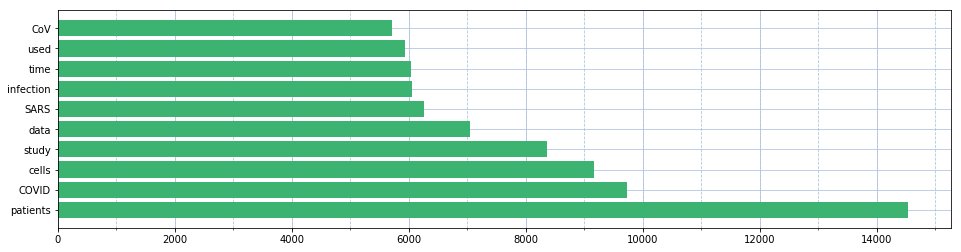

In [13]:
from matplotlib.ticker import MultipleLocator

def top_words(sorted_list, n):
    
    bars = [sorted_list[i][0] for i in range(0, n)]
    values = [sorted_list[i][1] for i in range(0, n)]
    
    y = np.arange(n)
    
    fig, ax = plt.subplots(figsize=(16, int(n*0.45)))
    
    # Plot
    ax.grid(True, color = "lightsteelblue")
    ax.barh(bars, values, color = "mediumseagreen") # horizontal barplot (barh)
    ax.set_axisbelow(True)
    ax.xaxis.set_minor_locator(MultipleLocator(1000))
    ax.grid(True, "minor", linestyle="--", color = "lightsteelblue")

top_words(word_count_ordered, 10)

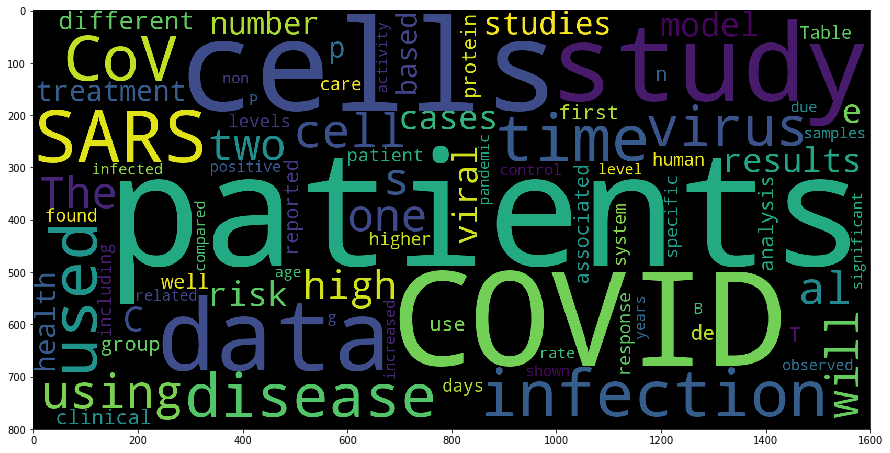

In [14]:
dd = {key: value for (key, value) in word_count}
wcloud = WordCloud(max_words = 80, width=1600, height=800).generate_from_frequencies(dd)
fig, ax = plt.subplots(figsize = (15, 15))
_ = ax.imshow(wcloud)

In [15]:
client.close()

## Timing

In [16]:
def timing(partitions):
    # Make client
    client = Client('10.67.22.190:8786')
    # Register start time
    start = time.time()
    
    # Load data and repartition
    filename = os.path.join('data', 'json_singleline', '*.json')
    lines = db.read_text(filename)

    # Algorithm
    word_count = (lines.map(json.loads).pluck('body_text').repartition(partitions)
                       .map(merge_text).map(clean_func)
                       .map(count_words).flatten()
                       .foldby('word', binop = incr, 
                               initial = 0, combine = lambda x,y: x+y, 
                               combine_initial = 0).compute())
    
    word_count_ordered = sorted(word_count, key = lambda x: x[1], reverse = True)
    
    # Register end time
    end = time.time()
    
    # Close client
    client.close()
    
    return end-start

### Algorithm used to compute the timings
The following algorithm has been used to compute the computation time as a function of the number of workers and partitions. For each fixed number of workers, we create a cluster from the terminal and iterate on the different number of partitions. Then, we save the results in order to visualize them.

Notice that there exists a way to create a distributed cluster with a chosen number of workers directly from Python, but a bug makes that cluster impossible to be closed from Python itself. This is why we couldn't iterate on the number of workers in a loop, but we had to create the cluster manually for every iteration.

In [17]:
if TIMING:
    # Number of workers
    workers = [8]
    # Partitions factor
    partitions = [1, 2, 4, 16, 32, 128, 400]
    # Partitions
    timings = np.zeros((len(workers),len(partitions)))
    # Printing timings
    for w_i, w in enumerate(workers):
        for p_i, p in enumerate(partitions):
            timings[w_i][p_i] = timing(p * w)
            print("nw: ", w, " partitions: ", p * w, " time [s]: ", timings[w_i][p_i])

    # Saving timings
    with open("times_words/words_08.npy", "wb") as f:
        np.save(f, timings)

Heatmap of execution times when varying the number of partitions per workers and number of workers. 

In [18]:
directory_path = './times_words/'

file_type = 'npy'
files=sorted([file for file in os.listdir(directory_path) if file.split('.')[-1]== file_type])

np_tot=np.zeros((len(files), 7) ) 
workers=[]

for i,file in enumerate(files ):
    np_tot[i,:]=np.load(directory_path+file)
    workers.append(int(file.split('_')[1].split('.')[0]) )

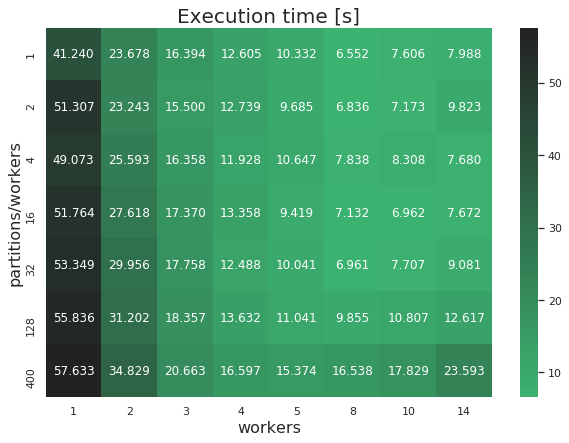

In [19]:
# Create a dataframe of timing results
df_timings = pd.DataFrame(np_tot.T,[1, 2, 4, 16, 32, 128, 400], workers)#,, partitions, workers)
# Heatmap
plt.figure(figsize=(10, 6.8))
sn.set(font_scale=1) # for label size
sn.heatmap(data=df_timings, annot=True, fmt=".3f",
               cmap=sn.dark_palette("mediumseagreen", reverse=True, as_cmap=True)
              )
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions/workers',fontsize=16)
plt.title("Execution time [s]", fontsize=20)
plt.show()
plt.style.use('default')

# 2. Most Productive Countries and Universities
In this section we figure out the countries and the universities that are most and less active in the research. <br>
We start by initializing a **Client** and pointing it to the address of the scheduler.

In [21]:
client = Client('10.67.22.190:8786')
client

Client Scheduler: tcp://10.67.22.190:8786 Dashboard: http://10.67.22.190:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.40 GB


We read the json as Dask Bag object. This is needed to perform operations in parallel.

In [22]:
# Load the data
filename = os.path.join('data', 'json_singleline', '*.json')
lines = db.read_text(filename)  # we read as a bag
js = lines.map(json.loads)

We select the *authors* field for each document because it is the one that  contains the Country and the University the authors belong to

In [23]:
# Pluck 'metadata' and then 'authors'
authors = js.pluck('metadata').pluck('authors')
authors.take(1)

([{'first': 'W',
   'middle': ['K'],
   'last': 'Lam',
   'suffix': '',
   'affiliation': {},
   'email': ''},
  {'first': 'C',
   'middle': ['K'],
   'last': 'Wong',
   'suffix': '',
   'affiliation': {},
   'email': ''},
  {'first': 'C',
   'middle': ['W K'],
   'last': 'Lam',
   'suffix': '',
   'affiliation': {},
   'email': ''},
  {'first': 'A',
   'middle': ['K L'],
   'last': 'Wu',
   'suffix': '',
   'affiliation': {},
   'email': ''},
  {'first': 'W',
   'middle': ['K'],
   'last': 'Ip',
   'suffix': '',
   'affiliation': {},
   'email': ''},
  {'first': 'N',
   'middle': ['L S'],
   'last': 'Lee',
   'suffix': '',
   'affiliation': {},
   'email': ''},
  {'first': 'I',
   'middle': ['H S'],
   'last': 'Chan',
   'suffix': '',
   'affiliation': {},
   'email': ''},
  {'first': 'L',
   'middle': ['C W'],
   'last': 'Lit',
   'suffix': '',
   'affiliation': {},
   'email': ''},
  {'first': 'D',
   'middle': ['S C'],
   'last': 'Hui',
   'suffix': '',
   'affiliation': {},
   'em

This function takes as argument one record and returns a dictionary with informations on the author in the record: *name*, *surname*, *University* and *Country*. <br>
We have to pay attention for the last three fields: for example, we may not have any information about them in the record. In this case, we use a placeholder value, i.e. a string "Unknown". <br>
Another problem is the presence of more than one way to represent one Country in the record. For that, we chose to unify all representations of one Country into one that is the same for everyone.
For example, The United Kingdom is also found in the record as "UK", "U.K", or "UK A R". In this case, the Country field in the returned dictionary will be "United Kingdom".<br>
In other papers the country is indicated in a strange way ("10 Austria", "France 15", ...) and for those papers we solved the issue in a similar way as before.

In [24]:
# Flatten information of the authors
def flatten(record):
    
    uni = loc = "Unknown"
    
    affiliation_keys = record['affiliation'].keys()
    
    if 'location' in affiliation_keys: # check location
        loc = record['affiliation']['location'].get("country", "Unknown")
    
    if 'institution' in affiliation_keys: # check institution
        uni = record['affiliation'].get("institution", "Unknown")
        
        
    if uni == "":
#         print("Warning: empty uni found")
        uni = "Unknown"
    if loc == "":
#         print("Warning: empty loc found")
        loc = "Unknown"
        
        
    # Some problems: 
    if loc in {'PR China', 'P.R. China', "People's Republic of China",'P. R. China'}: loc = "China"
            
    elif loc in {"UK","U.K", "UK A R"}: loc = "United Kingdom"
        
    elif loc in {"United States of America", "United States", "U.S.A", "U.S.A."} : loc = "USA"
        
    elif loc == "the Netherlands" : loc = "The Netherlands"
        
    elif loc == "Deutschland" : loc = "Germany"
        
    elif loc == "Republic of Korea" : loc = "Korea"

    elif loc == "10 Austria" : loc = "Austria"
        
    elif loc == "France 15" : loc = "France"
        
    elif loc == "Russian" : loc = "Russia"    
    
    return {
        'name':       record['first'],
        'surname':    record['last'], 
        'University': uni,
        'Country':    loc,
    }

# #check that the flatten function works as wanted 
authors.repartition(100).flatten().map(flatten).filter(lambda record: 
                                            tokenizer.tokenize(record["Country"]) == 
                                            word_tokenize(record["Country"], 
                                                          language = 'english')).take(1)

({'name': 'W',
  'surname': 'Lam',
  'University': 'Unknown',
  'Country': 'Unknown'},)

We construct a dataframe in which each row contains information about one author, starting from the *authors* bag. The dataframe has the advantage of being more performant with structured data with respect to dask.bags. Moreover, the dataframe object can be treated like a pandas.dataframe and this makes its use simpler. <br>
We specify the type of each column to improve the performance and to prevent dask from inferring the wrong type for the columns.<br>
Some countries present punctuation, due to the fact that the authors are not of the same country. We remove them comparing the output of two tokenizer: one that considers the punctuation and the other that skips them.

In [25]:
# Convert dataset to dataframe
authors_df = (authors.repartition(100)
              .flatten().map(flatten)
              .filter(lambda record: tokenizer.tokenize(record["Country"]) == 
                      word_tokenize(record["Country"], language = 'english'))
              .to_dataframe(meta = {"name": str, "surname": str, "University": str, "Country": str}))

authors_df.tail()

,name,surname,University,Country
89,Hajime,Senjo,Hokkaido University Faculty of medicine,Japan
90,Kasumi,Hayasaka,Hokkaido University Hospital,Japan
91,Satoshi,Konno,Hokkaido University Faculty of medicine,Japan
92,Mutsumi,Nishida,Hokkaido University Hospital,Japan
93,Takanori,Teshima,Hokkaido University Faculty of medicine,Japan


## Countries <br>
In the next cell we compute the number of occurrences for each Country, obtaining a Series object that shows which Countries are most/less productive. This is done calling the member function *value_counts()*, that compute the occurrence of each item. <br> 
The persist() function keeps the data in the RAM of the workers, avoiding the overhead caused by sending the data to the workers each time we need to analyze them. In this case, we call it because we will use **countries** multiple times in the following cells. Notice that the persist() command does not do anything until we trigger it: in our case, it will be triggered the first time we call the "plott" function.

In [26]:
countries = authors_df.Country.value_counts().persist()

Next function takes as arguments a Series object and eventually some option parameters. According to passed parameters, it prints or plots most/less productive Countries or Universities. <br>

In [27]:
def plott(data, n=10, small=False, small_univ=False, top_univ=False):
    if small == False:
        data = data.nlargest(n+1).compute()
        data = data[data.axes[0] != 'Unknown']  # try to comment to say something about the unknown
    
    elif small_univ==False:
        # here we delete (a posteriori) some strange names
        data = data[data==1].compute()
        data = data[data.axes[0] != 'China-Japan, China']
        data = data[data.axes[0] != 'University']
        low = [c for c in data.axes[0]]
        print("The less productive countries are:\n")
        for c in low: print("-", c)
        return
    
    else:
        data = data[data==1].compute()[:n]
        low = [c for c in data.axes[0]]
        print("{0} of the less productive universities are:\n".format(n))
        for c in low: print("-", c)
        return
    
    height = [data[i] for i in range(0, n)]
    bars = [data.axes[0][i] for i in range(0, n)]
    
    fig, ax = plt.subplots(figsize=(16, int(n)*0.4))
    
    # Plot
    if top_univ==False:
        ax.set_title("The most productive countries", size = 16)
    else:
        ax.set_title("The most productive universities", size = 16)
        
    ax.barh(bars, height[:n], color = "mediumseagreen")
    ax.grid(True, color = "lightsteelblue", linestyle="--")
    ax.set_axisbelow(True)
    ax.tick_params(labelsize=16)
    if max(height) > 200:
        ax.xaxis.set_minor_locator(MultipleLocator(20))
    else:
        ax.xaxis.set_minor_locator(MultipleLocator(1))

In [28]:
plott(countries, small=True)

The less productive countries are:

- Kenya
- UAE
- Bahrain
- Panama
- Slovakia
- Cuba
- Qatar A R
- Norway
- Indonesia
- Lao PDR
- Österreich


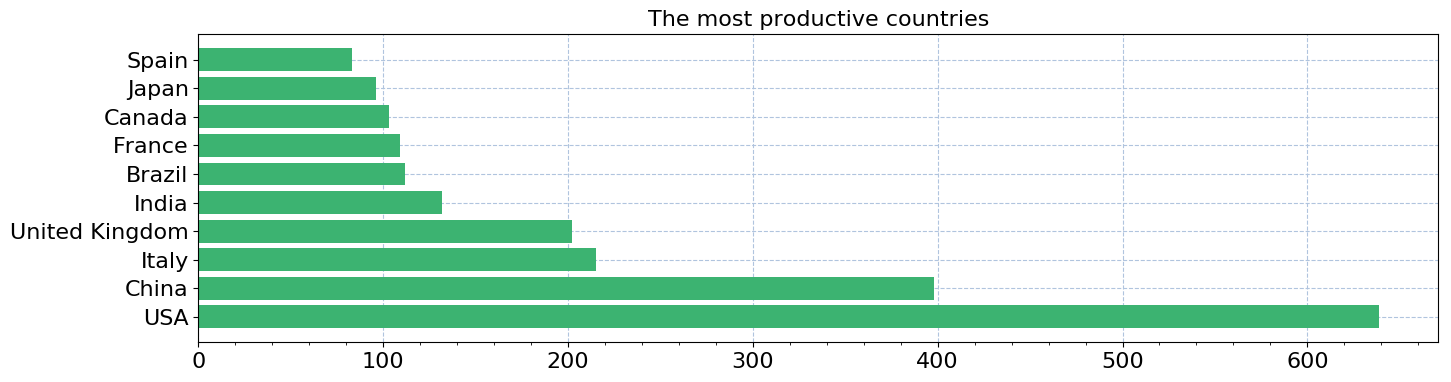

In [29]:
plott(countries, 10)

## Timing
Function to time the computation of the 10 most productive countries, given the number of partitions

In [30]:
def get_time_countries(partitions):
    
    # Make client
    client = Client('10.67.22.190:8786')
    # Register start time
    start = time.time() 
    
    # Load data and repartition
    filename = os.path.join('data', 'json_singleline', '*.json')
    lines = db.read_text(filename)
    

    authors_df = (lines.map(json.loads)
                    .pluck('metadata').pluck('authors').repartition(partitions)
                    .flatten().map(flatten).filter(lambda record: 
                                                   tokenizer.tokenize(record["Country"]) == 
                                                   word_tokenize(record["Country"], 
                                                                 language = 'english'))
                    .to_dataframe(meta = {"name": str, "surname": str, "University": str, "Country": str}))
    
    countries = authors_df.Country.value_counts().nlargest(10).compute()
    
    end = time.time()
    client.close() #close client
    return end - start

Compute and save the timings

In [31]:
if False:
    # Number of workers
    workers = [5]
    # Partitions factor
    partitions = [1, 2, 4, 16, 32, 64, 128] 

    times_countries = np.zeros((len(workers),len(partitions))) 

    for w in range(len(workers)):
        for p in range(len(partitions)):
            times_countries[w][p] = get_time_countries(partitions[p]*workers[w])
            print("nw: ", workers[w], " partitions: ", partitions[p]*workers[w], " time [s]: ", times_countries[w][p])

    with open("times_countries/countries_05.npy", "wb") as f:
        np.save(f, times_countries)

Heatmap of execution times when varying the number of partitions per workers and number of workers. 

In [32]:
directory_path = './times_countries/'

file_type = 'npy'
files=sorted([file for file in os.listdir(directory_path) if file.split('.')[-1]== file_type])

np_tot=np.zeros((len(files), 7) ) 
workers=[]

for i,file in enumerate(files ):
    np_tot[i,:]=np.load(directory_path+file)
    workers.append(int(file.split('_')[1].split('.')[0]) )

#     print(file)

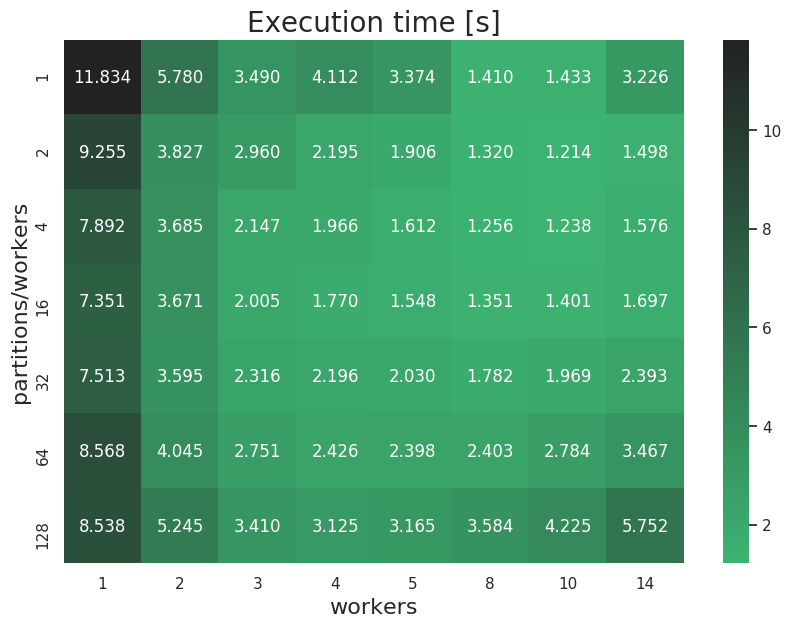

In [33]:
# Create a dataframe of timing results
df_timings = pd.DataFrame(np_tot.T,[1, 2, 4, 16, 32, 64, 128],workers)#,, partitions, workers)
# Heatmap
plt.figure(figsize=(10, 6.8))
sn.set(font_scale=1) # for label size
sn.heatmap(data=df_timings, annot=True, fmt=".3f",
               cmap=sn.dark_palette("mediumseagreen", reverse=True, as_cmap=True)
              )
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions/workers',fontsize=16)
plt.title("Execution time [s]", fontsize=20)
plt.show()
plt.style.use('default')

## Universities <br>
In the next cell we compute the number of occurrences for each University, obtaining a Series object that shows which Universities are most/less productive.

In [34]:
univs = (authors.repartition(100).
         flatten().map(flatten).
         to_dataframe(meta = {"name": str, "surname": str, "University": str, "Country": str})
         .University.value_counts().persist())

In [35]:
plott(univs, 20, small=True, small_univ=True)

20 of the less productive universities are:

- Hackensack University Medical Center
- Hallym University College of Medicine
- Hamadan University of Medical Sciences
- Zhongshan City People's Hospital
- IT University
- Hallym University college of Medicine
- Université Paris Descartes
- Hamad Medical Corporation (HMC)
- Alexandria University
- Hadassah-Hebrew University Medical Center
- A. Manzoni Hospital
- ISGlobal, Hospital Clínic-Universitat de Barcelona
- ISPRA
- IRCCS Mondino Foundation
- -Hospital Sírio Libanês
- Alessandro Manzoni Hospital
- & College of Pharmacy
- Acharya Institute of Technology
- Harold and Muriel Block Institute for Clinical and Translational Research
- IPS CardioDajud


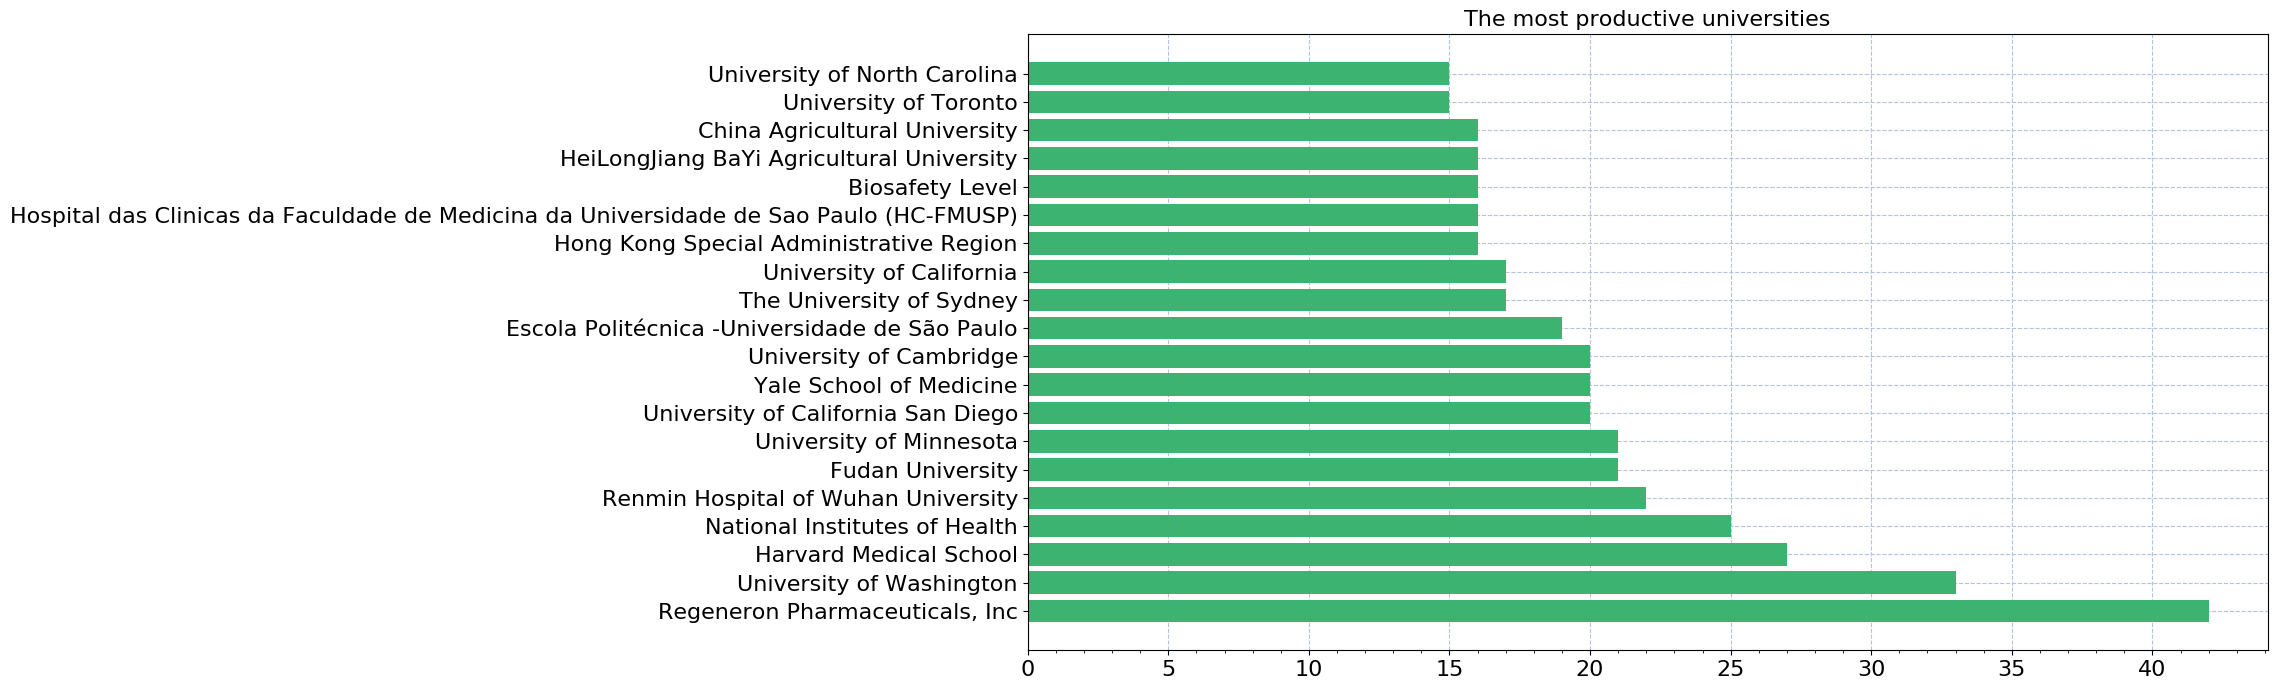

In [36]:
plott(univs, 20, top_univ = True)

## Timing
Function to time the computation of the 10 most productive universities, given the number of partitions

In [37]:
def get_time_univs(partitions):

    client = Client('10.67.22.190:8786')
    
    start = time.time()
    
    filename = os.path.join('data', 'json_singleline', '*.json')
    lines = db.read_text(filename)
    
    authors_df = (lines.map(json.loads)
                    .pluck('metadata').pluck('authors').repartition(partitions)
                    .flatten().map(flatten)
                    .to_dataframe(meta = {"name": str, "surname": str, "University": str, "Country": str}))
    
    univs = authors_df.University.value_counts().nlargest(10).compute()
    
    end = time.time()
    client.close() #close client
    return end-start

Compute and save the timings

In [38]:
if False:
    # Number of workers
    workers = [10]
    # Partitions factor
    partitions = [1, 2, 4, 16, 32, 64, 128] 

    times_univ = np.zeros((len(workers),len(partitions))) 

    for w in range(len(workers)):
        for p in range(len(partitions)):
            times_univ[w][p] = get_time_univs(partitions[p]*workers[w])
            print("nw: ", workers[w], " partitions: ", partitions[p]*workers[w], 
                  " time [s]: ", times_univ[w][p])
    with open("times_univs/univs_10.npy", "wb") as f:
        np.save(f, times_univ)

Heatmap of execution times when varying the number of partitions per workers and number of workers. 

In [39]:
directory_path = './times_univs/'

file_type = 'npy'
files=sorted([file for file in os.listdir(directory_path) if file.split('.')[-1]== file_type])

np_tot=np.zeros((len(files), 7) ) 
workers=[]

for i,file in enumerate(files ):
    np_tot[i,:]=np.load(directory_path+file)
    workers.append(int(file.split('_')[1].split('.')[0]) )

#     print(file)

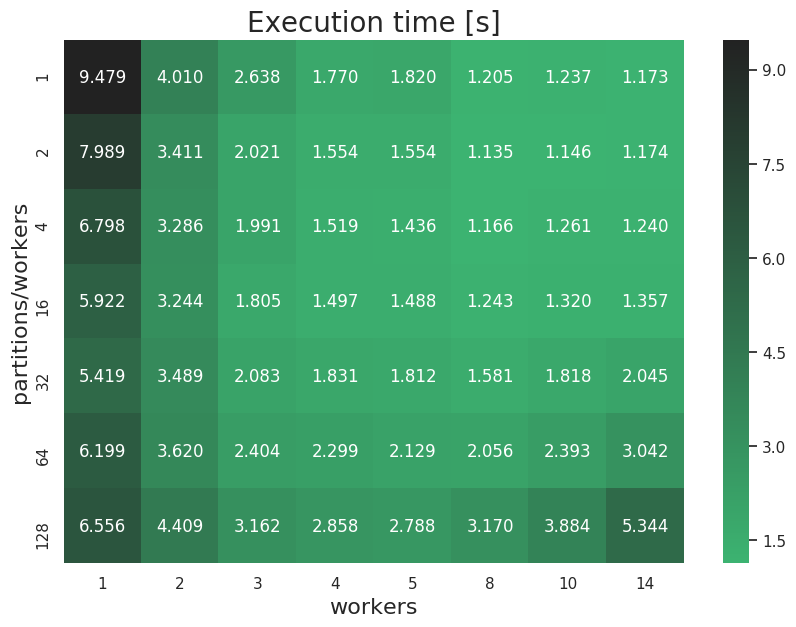

In [40]:
# Create a dataframe of timing results
df_timings = pd.DataFrame(np_tot.T,[1, 2, 4, 16, 32, 64, 128],workers)#,, partitions, workers)
# Heatmap
plt.figure(figsize=(10, 6.8))
sn.set(font_scale=1) # for label size
sn.heatmap(data=df_timings, annot=True, fmt=".3f",
               cmap=sn.dark_palette("mediumseagreen", reverse=True, as_cmap=True)
              )
plt.xlabel('workers',fontsize=16)
plt.ylabel('partitions/workers',fontsize=16)
plt.title("Execution time [s]", fontsize=20)
plt.show()
plt.style.use('default')

In [41]:
client.close()

## Comment on the timings
All the previous heatmaps about the timings show that both the workers and the partitions should not be neither too many nor too few.

As far as the partitions, their size should fit comfortably in memory but also not be too many, since every operation on every partition takes the central scheduler a few hundred microseconds to process. Moreover, having too many partitions means that a lot of chunks of data has to be transmitted through the cluster and this cause a lot of overhead.

As far as the workers, having more than one worker is good to distribute the code, but too many of them can cause overhead too, since the workers have to exchange data between each other and this operation takes a lot of time if the workers are too many. Another consideration that we can do about this aspect, is that it is not sensible to use a number of workers that is higher than the number of cores we have in our cluster, since the workers are supposed to execute tasks in parallel: looking at the heatmaps indeed, we can see that the computation time starts increasing when we set a number of workers greater than 8, that is the number of cores we have in our cluster.

# 3. Embedding for the title of the papers

In NLP a common technique to perform analysis over a set of texts is to transform the text to a set of vectors, each one representing a word inside the document. 
We transform the titles of the papers into their embedding version by using the pre-trained model available on FastText page https://fasttext.cc/docs/en/crawl-vectors.html.
* We load the data plucking only the metadata field of each paper, since it contains the title
* We load the english fasttext model
* We create one dictionary per paper, each one with its title and the embedding for it
* We save each dictionary in a .json file

In [42]:
if False:
    
    import fasttext

    def embed(text, model):
        
        text_split = text.split()
        text_list = [model[t] for t in text_split]
        text_string = [["%.10f" % n for n in emb] for emb in text_list]
        
        return text_string

    
    def dict_embed(text, model):
        
        return {
            "title": text,
            "emb_title": embed(text, model)
        }


    def embedding():
        # Import data
        filename = os.path.join('data', 'json_singleline', '*.json')
        lines = db.read_text(filename)
        js = lines.map(json.loads)
        titles = js.pluck("metadata").pluck("title").compute()

        # Load the FastText model
        ft = fasttext.load_model('cc.en.300.bin')

        # Get titles and embed them
        titles_emb = [dict_embed(d, ft) for d in titles]

        # Save embedded paper titles
        for i in range(len(titles_emb)):
            fname = "data/new_emb/embeddings"+str(i)+".json"
            with open (fname, 'w') as wf:
                json.dump(titles_emb[i], wf)


    client = Client('10.67.22.190:8786')   

    embedding()

    client.close()

In [44]:
client  = Client('10.67.22.190:8786')
client

Client Scheduler: tcp://10.67.22.190:8786 Dashboard: http://10.67.22.190:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.40 GB


Now we can load the embedded titles json files

In [45]:
# Load embedded papers
filename = os.path.join('data', 'embeddings', '*.json')
jfiles = db.read_text(filename).map(json.loads)
jfiles.take(1)

({'title': 'Plasma inflammatory cytokines and chemokines in severe acute respiratory syndrome',
  'emb_title': [['0.0179780778',
    '0.0610310212',
    '0.0514091067',
    '0.0119336043',
    '0.0383133069',
    '-0.0342295803',
    '0.0544443913',
    '-0.0438884012',
    '-0.0255027022',
    '-0.1600893885',
    '-0.0631421208',
    '-0.0346374400',
    '-0.0694727302',
    '-0.0476796925',
    '0.0126695549',
    '0.0481020324',
    '0.1033288166',
    '-0.0134457452',
    '-0.0230915360',
    '0.0095322421',
    '0.0111391805',
    '-0.0126392692',
    '0.0422238111',
    '-0.0236146357',
    '0.0950958356',
    '0.0068730386',
    '-0.0092170276',
    '-0.0240158867',
    '-0.0792038664',
    '0.0995018706',
    '0.0013987571',
    '0.1105756983',
    '0.0172082502',
    '0.0815243348',
    '0.0238117855',
    '-0.0196268894',
    '-0.0114727272',
    '0.0105287535',
    '0.0734981075',
    '-0.0900465846',
    '-0.0880422294',
    '0.0961950645',
    '-0.0415551290',
    '-0.052

# 4. Cosine Similarities (Bonus Point)

In this section we compute the cosine similarity between the titles of the papers using the embeddings generated in the previous part of the notebook.

In order to compute the cosine similarity, we need to convert back the embeddings from string to array. To this end, we define two functions and we map them to the dask bag that contains the embedddings for the titles of the papers.

In [46]:
def string_to_float(title):
    return np.array([[float(w) for w in word] for word in title])


def float_db(record):
    return {
        "title": record['title'],
        "embedding": string_to_float(record['emb_title'])
    }

titles_emb = db.from_sequence(jfiles.map(float_db)).compute() # list of dictionaries
print(titles_emb[0]) # dictionary with the paper_id and the embedding for the title

{'title': 'Plasma inflammatory cytokines and chemokines in severe acute respiratory syndrome', 'embedding': array([[ 0.01797808,  0.06103102,  0.05140911, ...,  0.08014752,
        -0.08337525, -0.1715014 ],
       [ 0.03421387, -0.03820885,  0.02541273, ...,  0.05750369,
        -0.00442151,  0.02916642],
       [ 0.05716168,  0.01199805,  0.03511237, ...,  0.04666892,
         0.00715215, -0.00947358],
       ...,
       [-0.02796585, -0.10948253, -0.01058279, ...,  0.11238649,
         0.01936976, -0.04341067],
       [ 0.02379685, -0.00837636,  0.034144  , ...,  0.07967162,
         0.06711587, -0.02432768],
       [ 0.04758655, -0.02603945, -0.0574972 , ...,  0.03749585,
        -0.02582056,  0.09057393]])}


Each embedding is a list of vectors, with one vector for each word of the title. As a consequence, the embeddings are not all of the same length, so we have to cut some of them in order to be able to compute the cosine similarity: to this end, we compute the minimum length between the two titles we are analyzing and cut the larger one. For example, if two titles have 10 and 16 words respectively, we compute the cosine of the first 10 words.

In [47]:
import math
# Function to compute the cosine similarity
def cos_sim(x,y):
    # we flatten the list of vectors first
    x = x.flatten()
    y = y.flatten()
    # we compute where to cut the longer vector
    m   = min(len(x), len(y))
    # cosine similarity
    xx  = np.sqrt(np.dot(x,x))
    yy  = np.sqrt(np.dot(y,y))
    cosine = np.dot(x[:m], y[:m])/(xx*yy)
    
    if math.isnan(cosine): # check for nan
        return 0.
    else:
        return cosine

# Function for computing the cosine similarity with dask.bag
def cos_sim_bag(db):
    
    s = cos_sim(db[0]['embedding'], db[1]['embedding'])
    
    return {
        "Paper_1": db[0]['title'],
        "Paper_2": db[1]['title'],
        "Cosine_Similarity": s
    }

Before starting the computation, let us checking whether or not it is worth to use dask in this case

In [48]:
%%time

dask = (db.from_sequence([(titles_emb[i], titles_emb[j]) for i in range(100) for j in range(i+1, 100)])
                .map(cos_sim_bag).compute())

CPU times: user 5.5 s, sys: 114 ms, total: 5.61 s
Wall time: 6.54 s


This approach scales badly with the number of papers (even if we increase the number of partitions), making impossible to apply the previous code to the full dataset. The serial approach is much faster instead, as we show with the following cells: it takes about 1 ms, making the distributed approach pointless.

In [49]:
# Function for computing the cosine similarity with arrays
def cos_sim_array(record1, record2):
    
    s = cos_sim(record1['embedding'], record2['embedding'])

    return {
        "Paper_1": record1['title'],
        "Paper_2": record2['title'],
        "Cosine_Similarity": s
    }

In [50]:
%%time
sim_ser = [cos_sim_array(titles_emb[i], titles_emb[j]) for i in range(100) for j in range(i+1, 100)]

CPU times: user 214 ms, sys: 332 ms, total: 546 ms
Wall time: 145 ms


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


As a consequence, in the following cell we **serially** compute all the similarities between the papers.

In [51]:
L = len(titles_emb)

simil = [cos_sim_array(titles_emb[i], titles_emb[j]) for i in range(L) for j in range(i+1, L)]

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


So, we save the data in a pandas data frame. We do not use the dask dataframe in this case since we do not perform complex operations with this dataset, so it is faster to use pandas directly, as we checked using the %%TIMIEIT function.

In [52]:
simil_df = pd.DataFrame(simil)

print("Number of perfect similarities:", len(simil_df[simil_df['Cosine_Similarity'] >  0.999]))
simil_df.head()

Number of perfect similarities: 5


,Paper_1,Paper_2,Cosine_Similarity
0,Plasma inflammatory cytokines and chemokines i...,Porcine epidemic diarrhea virus N protein prol...,0.068285
1,Plasma inflammatory cytokines and chemokines i...,Journal Pre-proof Trombosis de la vena mesenté...,0.042059
2,Plasma inflammatory cytokines and chemokines i...,"QT prolongation in a diverse, urban population...",0.112272
3,Plasma inflammatory cytokines and chemokines i...,How digital health solutions align with the ro...,0.053854
4,Plasma inflammatory cytokines and chemokines i...,Deep phenotyping detects a pathological CD4 + ...,0.093806


Here we compute the 10 papers with the highest cosine similarity and then we print them.

In [53]:
simil_df_largest = simil_df.nlargest(10, ['Cosine_Similarity'])

for i in range(10):
    print(i+1, "-----------------------------------------------------------------------------------------------")
    print("  Title 1:             ", simil_df_largest.iloc[i]['Paper_1'])
    print("  Title 2:             ", simil_df_largest.iloc[i]['Paper_2'])
    print("  Cosine Similarity:   ", simil_df_largest.iloc[i][2])

1 -----------------------------------------------------------------------------------------------
  Title 1:              Journal Pre-proof
  Title 2:              Journal Pre-proof
  Cosine Similarity:    1.0
2 -----------------------------------------------------------------------------------------------
  Title 1:              Journal Pre-proof
  Title 2:              Journal Pre-proof
  Cosine Similarity:    1.0
3 -----------------------------------------------------------------------------------------------
  Title 1:              Journal Pre-proof
  Title 2:              Journal Pre-proof
  Cosine Similarity:    1.0
4 -----------------------------------------------------------------------------------------------
  Title 1:              0123456789) 1 3 Clinical Research in Cardiology
  Title 2:              0123456789) 1 3 Clinical Research in Cardiology
  Cosine Similarity:    1.0
5 -----------------------------------------------------------------------------------------------
  

In [54]:
client.close()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d6e6414-063e-46fb-9f41-99a00d9b27db' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>